In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# 1. Import the data

In [2]:
def extract_numerical_categorical_features(data:pd.DataFrame, label:str):
    """
    Extract the categorical and numerical features of a dataset
    Args:
    data: the dataframe
    label: the label we do not want to import
    """
    numerical_features = [key for key, value in data.dtypes.items() if value=="float64" and key!=label]
    print(f"Numerical features: {numerical_features}")

    #categorical_features = [key for key, value in data.dtypes.items() if value=="object" and key!=label]
    categorical_features = [col for col in data.columns if col not in numerical_features and col!=label]
    print(f"Categorical features: {categorical_features}")
    
    return numerical_features, categorical_features

In [3]:
#Import the data obtained after the 2nd milestone
data = pd.read_csv("Big_Cleaned_dataset.csv", index_col=0)
data.head(2)

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country
0,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",F,1.62,NaN,Wanda De Jesus,42.0,Thriller,United States of America
1,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",F,1.78,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America


# 2. Process the countries into regions

In [4]:
#Check how many countries we have
data['Main_country'].value_counts()

Main_country
United States of America    134089
India                        14376
France                        9734
United Kingdom                9557
Japan                         5788
                             ...  
Armenia                          1
Nigeria                          1
Palestinian territories          1
Bhutan                           1
Algeria                          1
Name: count, Length: 103, dtype: int64

In [5]:
#Associate a region to each country
data["Region"] = data["Main_country"].copy().apply(country_to_region)
data["Region"].value_counts()

Region
North America    136883
West Europa       31159
Asia              25106
East Europa        2795
Oceania            2027
South America       696
Dead country        402
Africa              218
Name: count, dtype: int64

In [6]:
#Verify if we didn't forget any country
data[data["Region"]=="Unknown region"]["Main_country"].unique()

array([], dtype=object)

# 3. Clustering the genres

In [7]:
data['Movie_genres'] = data['Movie_genres'].apply(string2dict)
df2 = data.drop_duplicates(subset='Movie_name',inplace=False)

In [8]:
all_genres = df2['Movie_genres'].explode()

genre_counts = all_genres.value_counts() #type series
print(genre_counts.sum()) #length 293 genres différents

prop_genre = genre_counts/genre_counts.sum()
#print(prop_genre)

cum_prop_genre = prop_genre.cumsum()
#print(cum_prop_genre)

genre_95 = cum_prop_genre[cum_prop_genre<=0.50]

#print(genre_95.index)

print(genre_counts[genre_95.index])
print(genre_counts[genre_95.index].sum())
print(len(genre_95.index))

111029
Movie_genres
Drama              14216
Comedy              8442
Romance Film        4963
Black-and-white     4652
Thriller            4344
Action              4079
Indie               3530
Crime Fiction       3212
World cinema        2823
Short Film          2749
Name: count, dtype: int64
53010
10


In [9]:
MLB = MultiLabelBinarizer()
genres_matrix = MLB.fit_transform(df2['Movie_genres'])
print(genres_matrix.shape) # il y'a 293 différents genres

(29466, 343)


In [10]:
genres_df = pd.DataFrame(genres_matrix, columns=MLB.classes_, index=df2['Movie_name']) #convertit la mtrice en df
df_film_genres = genres_df[genre_95.index]
df_film_genres.head()

,Drama,Comedy,Romance Film,Black-and-white,Thriller,Action,Indie,Crime Fiction,World cinema,Short Film
Movie_name,,,,,,,,,,
Ghosts of Mars,0,0,0,0,1,1,0,0,0,0
Getting Away with Murder: The JonBenét Ramsey Mystery,1,0,0,0,0,0,0,0,0,0
The Gangsters,0,1,0,1,0,0,1,0,0,1
Alexander's Ragtime Band,0,1,0,1,0,0,0,0,0,0
Little city,1,1,1,0,0,0,0,0,0,0


In [11]:
def plot_sse(features_X, start=2, end=10):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

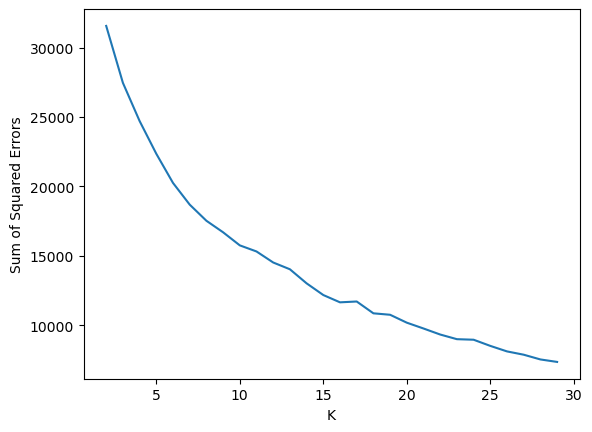

In [12]:
plot_sse(df_film_genres, start=2, end=30) #nous permet d'identifier que 10 c'est top ! 

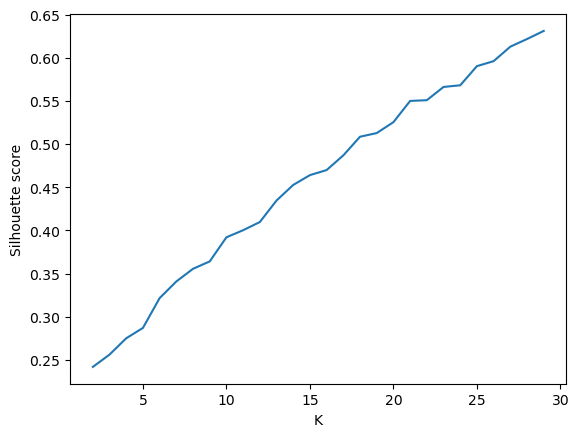

In [13]:
silhouettes = []
# Try multiple k
for k in range(2, 30):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(df_film_genres)
    # Get the Silhouette score
    score = silhouette_score(df_film_genres, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()

In [14]:
kmeans = KMeans(n_clusters=15, random_state=42)
df_film_genres['Cluster'] = kmeans.fit_predict(df_film_genres)

In [15]:
df_film_genres.shape

(29466, 11)

In [16]:
cluster_counts = df_film_genres['Cluster'].value_counts()
print(cluster_counts)

Cluster
1     5265
2     4551
5     3606
8     2329
3     1592
7     1498
13    1477
9     1409
6     1343
0     1319
10    1113
11    1093
12     997
14     952
4      922
Name: count, dtype: int64


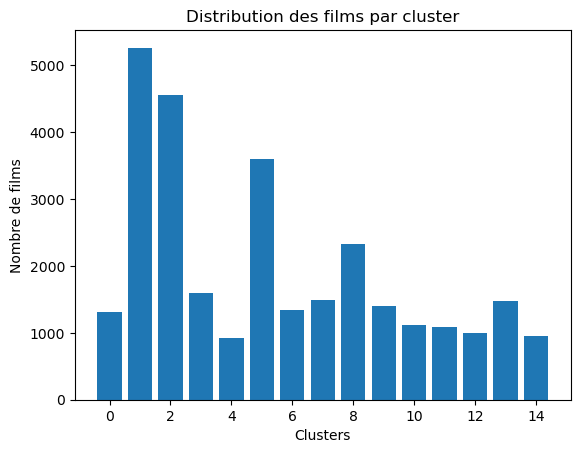

In [17]:
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Clusters')
plt.ylabel('Nombre de films')
plt.title('Distribution des films par cluster')
plt.show()

In [18]:
cluster_names = {}

for cluster_id in np.unique(kmeans.labels_):
    print(cluster_id)
    cluster_films = df_film_genres[df_film_genres['Cluster'] == cluster_id].drop(columns=['Cluster'])
    genre_sum = cluster_films.sum()
    top_genres = genre_sum.sort_values(ascending=False).head(5)
    print(top_genres)
    
## By counting and printing how much each genres appears in each cluster, 
# we are able to name the clusters by hand. This is done below

cluster_names = {
    0: "Comedy - Short film",
    1: "Drama - Thriller",
    2: "Short film - World cinema",
    3: "Crime - Thriller",
    4: "Drama - Comedy",
    5: "Comedy - Action",
    6: "Drama",
    7: "Drama - Romance",
    8: "Action - Thriller",
    9: "Drama - Indie",
    10: "B&W - Indie",
    11: "Drama - B&W",
    12: "Drama - Comedy",
    13: "Romance - Comedy",
    14: "Thriller"
}

0
Comedy             1319
Short Film         1273
Black-and-white    1009
Indie               701
Drama                10
dtype: int64
1
Drama            5265
Thriller          487
Crime Fiction     426
Short Film        125
Comedy              0
dtype: int64
2
Short Film       549
World cinema     251
Crime Fiction    209
Indie            167
Drama              0
dtype: int64
3
Crime Fiction    1592
Thriller         1472
Drama            1111
Action            693
World cinema      180
dtype: int64
4
Drama           922
Comedy          922
Romance Film    922
World cinema    222
Indie           167
dtype: int64
5
Comedy             3606
Action              449
Black-and-white     363
Crime Fiction       255
Indie               236
dtype: int64
6
World cinema    1343
Drama           1336
Romance Film     556
Thriller         162
Action           114
dtype: int64
7
Drama              1498
Romance Film       1498
Black-and-white     164
Action              146
Crime Fiction        98
dty

In [19]:
df_film_genres['Cluster_Name'] = df_film_genres['Cluster'].map(cluster_names)
df_film_genres.head()

,Drama,Comedy,Romance Film,Black-and-white,Thriller,Action,Indie,Crime Fiction,World cinema,Short Film,Cluster,Cluster_Name
Movie_name,,,,,,,,,,,,
Ghosts of Mars,0,0,0,0,1,1,0,0,0,0,8,Action - Thriller
Getting Away with Murder: The JonBenét Ramsey Mystery,1,0,0,0,0,0,0,0,0,0,1,Drama - Thriller
The Gangsters,0,1,0,1,0,0,1,0,0,1,0,Comedy - Short film
Alexander's Ragtime Band,0,1,0,1,0,0,0,0,0,0,5,Comedy - Action
Little city,1,1,1,0,0,0,0,0,0,0,4,Drama - Comedy


In [20]:
df = data.merge(df_film_genres[['Cluster', 'Cluster_Name']], left_on='Movie_name', right_index=True, how='left')

df.head()

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country,Region,Cluster,Cluster_Name
0,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.620,NaN,Wanda De Jesus,42.0,Thriller,United States of America,North America,8,Action - Thriller
1,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.780,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America,North America,8,Action - Thriller
2,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",M,1.727,/m/0x67,Ice Cube,32.0,Thriller,United States of America,North America,8,Action - Thriller
3,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",M,1.750,NaN,Jason Statham,33.0,Thriller,United States of America,North America,8,Action - Thriller
4,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",F,1.650,NaN,Clea DuVall,23.0,Thriller,United States of America,North America,8,Action - Thriller


# 4. Filtering/Creating new sub-dataset

In [21]:
label = ["Actor_gender_male"]
col2rename = {"Actor_gender":label[0], "Movie_box_office_revenue":"Movie_box_office_scaled", "Actor_height_m":"Actor_height_scaled"}

## 4.1 Handle genders

In [22]:
#Delete the rows that have a "Unknown" gender which is useless for our analysis
df = df.query("Actor_gender != 'Unknown' ")

#One-hot encoding for the label(gender)
df["Actor_gender"] = df["Actor_gender"].apply(lambda x: 1 if x=="M" else 0)

df.head()

,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Main_genre,Main_country,Region,Cluster,Cluster_Name
0,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",0,1.620,NaN,Wanda De Jesus,42.0,Thriller,United States of America,North America,8,Action - Thriller
1,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",0,1.780,/m/044038p,Natasha Henstridge,27.0,Thriller,United States of America,North America,8,Action - Thriller
2,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",1,1.727,/m/0x67,Ice Cube,32.0,Thriller,United States of America,North America,8,Action - Thriller
3,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",1,1.750,NaN,Jason Statham,33.0,Thriller,United States of America,North America,8,Action - Thriller
4,Ghosts of Mars,2001.0,14010832.0,98.0,['English'],['United States of America'],"[Thriller, Science Fiction, Horror, Adventure,...",0,1.650,NaN,Clea DuVall,23.0,Thriller,United States of America,North America,8,Action - Thriller


In [23]:
df = df.rename(columns=col2rename)
test = df.copy()

In [34]:
df = test.copy()

## 4.3 Scale height and box office

In [35]:
#Scale the actor height: we create a ratio of size for each gender based on their mean height
mean_height_male = 1.7429 #m
mean_height_female = 1.57 #m

#df['Actor_height_scaled'] = min_max_scaling(df['Actor_height_scaled'] * (df[label[0]] == 1)) + min_max_scaling(df['Actor_height_scaled'] * (df[label[0]] != 1))
#df['Actor_height_scaled'] = standardize_scaling(df['Actor_height_scaled'] * (df[label[0]] == 1)) + standardize_scaling(df['Actor_height_scaled'] * (df[label[0]] != 1))
df['Actor_height_scaled'] = df['Actor_height_scaled']/mean_height_male * (df[label[0]] == 1) + df['Actor_height_scaled']/mean_height_female * (df[label[0]] != 1)

In [36]:
#Scale the box office revenue based on the inflation
df_CPI = pd.read_csv("CPI.csv") # dataset with the CPI of the dollard for the years of interest based on the year 1984
base = 100 # corrspond to 1984
df_CPI['year'] = pd.to_datetime(df_CPI['observation_date'], errors='coerce').dt.year
df = pd.merge(df, df_CPI, left_on = 'Movie_release_date', right_on= 'year', how = 'left') # associate the CPI with the movie year release
df["Movie_box_office_scaled"] = df["Movie_box_office_scaled"] / df["CPIAUCNS"] * base

## 4.5 Delete the useless columns

In [37]:
numerical_features = ["Movie_release_date", "Movie_box_office_scaled", "Movie_runtime",
                      "Actor_age_at_movie_release", "Actor_height_scaled"]
categorical_features = ["Cluster_Name", "Region"]

In [38]:
#Delete all columns that we do not care
## For Léo's analysis
df_countries = df.drop(columns=[col for col in df.columns if col not in 
                                  ["Movie_name","Movie_release_date","Movie_box_office_scaled","Actor_gender_male",
                                   "Main_country", "Region"]])

## For the others
df = df.drop(columns=[col for col in df.columns if col not in 
                        (numerical_features + categorical_features + label + ["Movie_name"])])

In [39]:
#One-hot encoding for the categorical features (genre, region)
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

#Standardization of the data
df_std = df.copy()
df_std[[col for col in df.columns if col in numerical_features]] = StandardScaler().fit_transform(
                                                        df[[col for col in df.columns if col in numerical_features]])

## 4.5 One-hot encoding and standardization

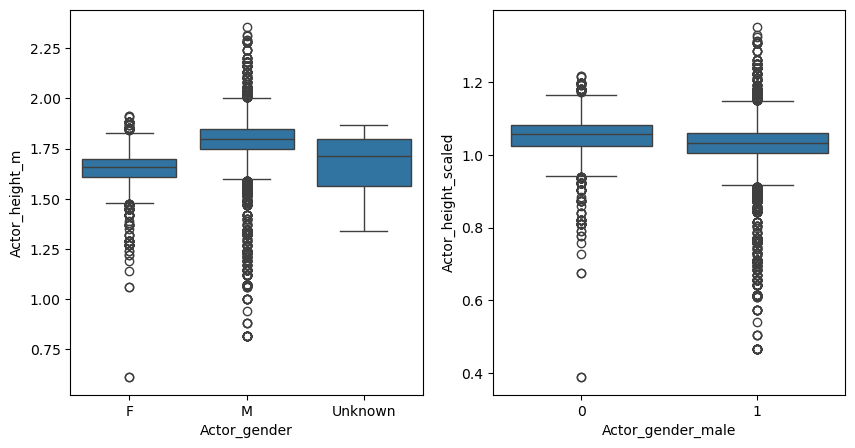

In [41]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.boxplot(data = data, x=data["Actor_gender"], y=data["Actor_height_m"])
plt.subplot(1,2,2)
sns.boxplot(data = df, x=df[label[0]], y=df["Actor_height_scaled"])
plt.show()

In [42]:
df_countries

,Movie_name,Movie_release_date,Movie_box_office_scaled,Actor_gender_male,Main_country,Region
0,Ghosts of Mars,2001.0,7.912729e+06,0,United States of America,North America
1,Ghosts of Mars,2001.0,7.912729e+06,0,United States of America,North America
2,Ghosts of Mars,2001.0,7.912729e+06,1,United States of America,North America
3,Ghosts of Mars,2001.0,7.912729e+06,1,United States of America,North America
4,Ghosts of Mars,2001.0,7.912729e+06,0,United States of America,North America
...,...,...,...,...,...,...
199107,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,0,Japan,Asia
199108,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,1,Japan,Asia
199109,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,1,Japan,Asia
199110,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,1,Japan,Asia


In [43]:
df

,Movie_name,Movie_release_date,Movie_box_office_scaled,Movie_runtime,Actor_gender_male,Actor_height_scaled,Actor_age_at_movie_release,Cluster_Name_B&W - Indie,Cluster_Name_Comedy - Action,Cluster_Name_Comedy - Short film,...,Cluster_Name_Romance - Comedy,Cluster_Name_Short film - World cinema,Cluster_Name_Thriller,Region_Asia,Region_Dead country,Region_East Europa,Region_North America,Region_Oceania,Region_South America,Region_West Europa
0,Ghosts of Mars,2001.0,7.912729e+06,98.0,0,1.031847,42.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,Ghosts of Mars,2001.0,7.912729e+06,98.0,0,1.133758,27.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,Ghosts of Mars,2001.0,7.912729e+06,98.0,1,0.990877,32.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,Ghosts of Mars,2001.0,7.912729e+06,98.0,1,1.004074,33.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,Ghosts of Mars,2001.0,7.912729e+06,98.0,0,1.050955,23.0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199107,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,0,NaN,25.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
199108,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,1,NaN,52.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
199109,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,1,NaN,32.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
199110,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,1,NaN,32.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [44]:
df_std

,Movie_name,Movie_release_date,Movie_box_office_scaled,Movie_runtime,Actor_gender_male,Actor_height_scaled,Actor_age_at_movie_release,Cluster_Name_B&W - Indie,Cluster_Name_Comedy - Action,Cluster_Name_Comedy - Short film,...,Cluster_Name_Romance - Comedy,Cluster_Name_Short film - World cinema,Cluster_Name_Thriller,Region_Asia,Region_Dead country,Region_East Europa,Region_North America,Region_Oceania,Region_South America,Region_West Europa
0,Ghosts of Mars,0.662661,-0.388863,-0.144006,0,-0.195663,0.213048,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,Ghosts of Mars,0.662661,-0.388863,-0.144006,0,1.829383,-0.825484,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,Ghosts of Mars,0.662661,-0.388863,-0.144006,1,-1.009765,-0.479307,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,Ghosts of Mars,0.662661,-0.388863,-0.144006,1,-0.747543,-0.410071,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,Ghosts of Mars,0.662661,-0.388863,-0.144006,0,0.184033,-1.102427,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199107,The Super Dimension Fortress Macross II: Lover...,0.327775,NaN,1.443902,0,NaN,-0.963955,False,False,False,...,False,False,False,True,False,False,False,False,False,False
199108,The Super Dimension Fortress Macross II: Lover...,0.327775,NaN,1.443902,1,NaN,0.905403,False,False,False,...,False,False,False,True,False,False,False,False,False,False
199109,The Super Dimension Fortress Macross II: Lover...,0.327775,NaN,1.443902,1,NaN,-0.479307,False,False,False,...,False,False,False,True,False,False,False,False,False,False
199110,The Super Dimension Fortress Macross II: Lover...,0.327775,NaN,1.443902,1,NaN,-0.479307,False,False,False,...,False,False,False,True,False,False,False,False,False,False


# 5. Exporting the data

In [45]:
df.to_csv("data_cleaned.csv")
df_std.to_csv("data_cleaned_standardized.csv")
df_countries.to_csv("data_cleaned_countries.csv")